In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
from scipy.ndimage import gaussian_filter
import time

# Import the MFI library 
import MFI_lib2D as lib2
import MFI_class2D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_SRTR"): print("\nThe data folder \"_data_SRTR\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_SRTR/"); 
    path_data = path_notebook + "/_data_SRTR/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})

t_compare, aofe_compare, _, aad_compare, _ = lib2.load_pkl(path_notebook + f"/error_progressions/error_progression_long_inve.pkl")


The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class2D

The data folder "_data_SRTR" does not exist. Creating new folder.
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_SRTR/


In [15]:
os.chdir(path_notebook); reload(MFI_class2D); reload(lib2); pass

## Invernizzi Potential

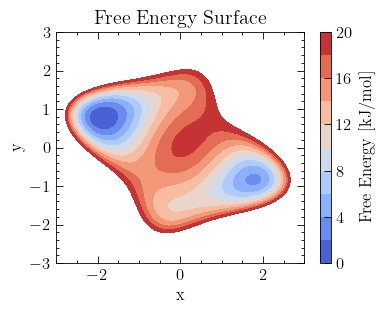

In [2]:
# Define the grid, the potential, the string of the potential and the FES cutoff
grid = np.linspace(-3, 3, 100); 
X, Y = np.meshgrid(grid, grid)
inve_pot = 1.34549*X**4+1.90211*X**3*Y+3.92705*X**2*Y**2-6.44246*X**2-1.90211*X*Y**3+5.58721*X*Y+1.33481*X+1.34549*Y**4-5.55754*Y**2+0.904586*Y+18.5598
inve_pot = inve_pot - np.min(inve_pot)
inve_pot_string = "1.34549*x^4+1.90211*x^3*y+3.92705*x^2*y^2-6.44246*x^2-1.90211*x*y^3+5.58721*x*y+1.33481*x+1.34549*y^4-5.55754*y^2+0.904586*y+18.5598"
FES_cutoff = 20

# Define plumed grid
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

# plot the free energy surface
plt.contourf(X, Y, inve_pot, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Free Energy Surface"); plt.show()

# Stimulation path
path_invernizzi = path_data + "Invernizzi_Potential/"

### MFI2D run SRTR

In [3]:
   # default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":inve_pot, "bw":[0.1, 0.1], "System":"Langevin", 
                    # "position_pace":50, "n_pos_per_window":10, "metad_pace":500,
                    "position_pace":50, "n_pos_per_window":10, "metad_pace":500,
                    "Bias_sf":0.95, "gaus_filter_sigma":1,
                    "FES_cutoff":FES_cutoff, 
                    # "calculate_FES_st_dev":True, "bootstrap_iter":50,
                    "simulation_folder_path": path_invernizzi,	
                    }

In [5]:
MFI = MFI_class2D.MFI2D(**default_params)

MFI.MFI_real_time_ReInit(ID="_test", goal=0.1, main_error_type="AAD", n_pos_before_analysis=1000, guaranteed_sim_time=50, max_sim_time=50,
                         time_budget=30)
                        #  restart_SRTR=True, time_budget=80)

MFI.plot_results(t_compare=t_compare, aofe_compare=aofe_compare, aad_compare=aad_compare)

print(f"\n~~~~~~ END ~~~~~~\n\n{MFI.Aofe = :.4f}, {MFI.AAD = :.4f}")

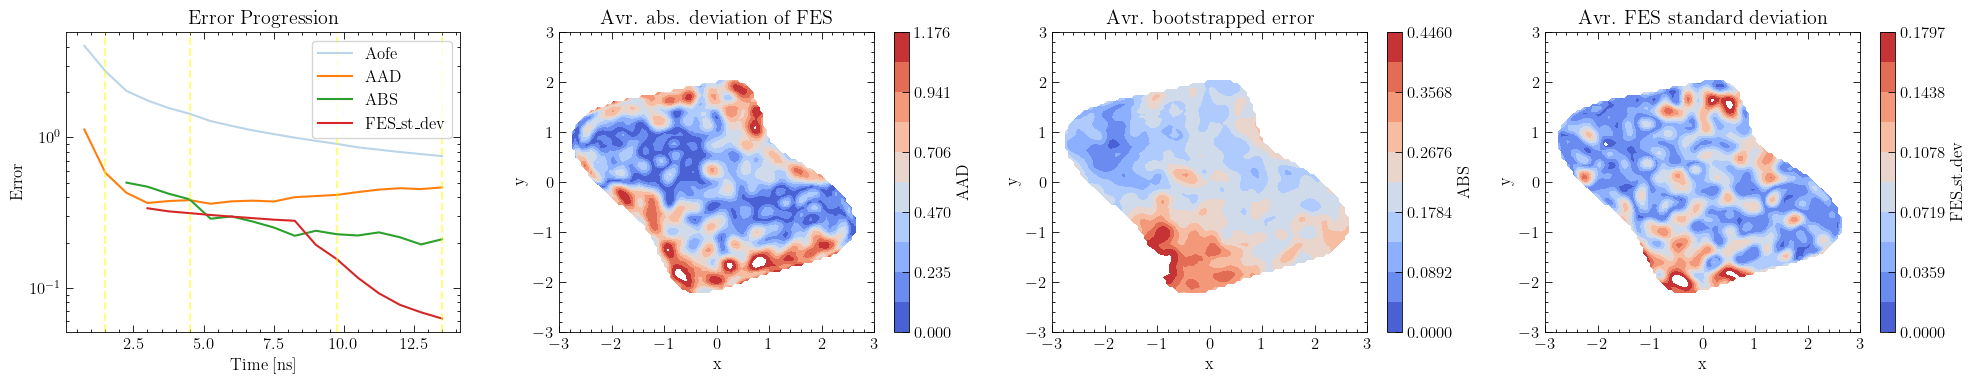

In [121]:
### Plot different error progreesions and maps    
lib2.plot_multiple_error_prog_and_maps(MFI, error_types=["AAD", "ABS", "FES_st_dev"])


Block size 1: sd_fes = 0.1803,  length=18
Block size 3: sd_fes = 0.2388,  length=6
Block size 5: sd_fes = 0.1433,  length=4


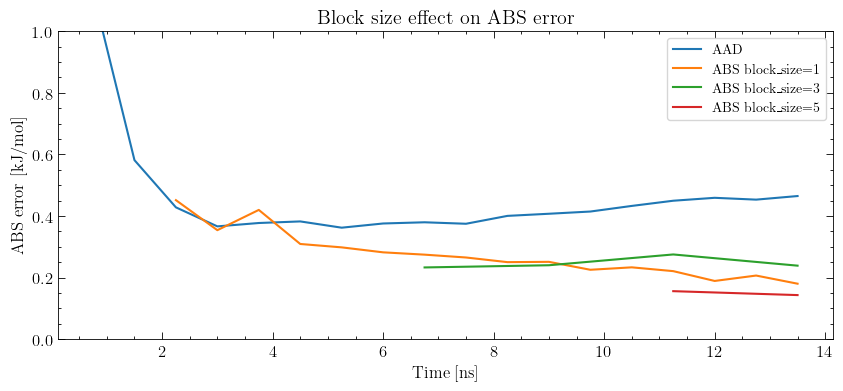

In [85]:
### bootstrap error with increasing BLOCK SIZE
n_bootstrap = 100
plt.figure(figsize=(10,4))
plt.plot(MFI.Avr_Error_list[:,0], MFI.Avr_Error_list[:,MFI.aad_index], label="AAD")

for block_size in [1, 3, 5]:#10]:
    _, _, _, sd_fes_evo_bs, time_bs = lib2.bootstrapping_progression(X,Y,MFI.forces_e_list, time_array=MFI.Avr_Error_list[:,0], n_bootstrap=n_bootstrap, block_size=block_size, periodic=MFI.periodic, FES_cutoff=MFI.FES_cutoff)
    print(f"Block size {block_size}: sd_fes = {sd_fes_evo_bs[-1]:.4f},  length={len(sd_fes_evo_bs)}")
    plt.plot(time_bs, sd_fes_evo_bs, label=f"ABS block_size={block_size}")

plt.ylim(0, 1); plt.title("Block size effect on ABS error"); plt.xlabel("Time [ns]"); plt.ylabel("ABS error [kJ/mol]"); plt.legend(fontsize=10); plt.show()

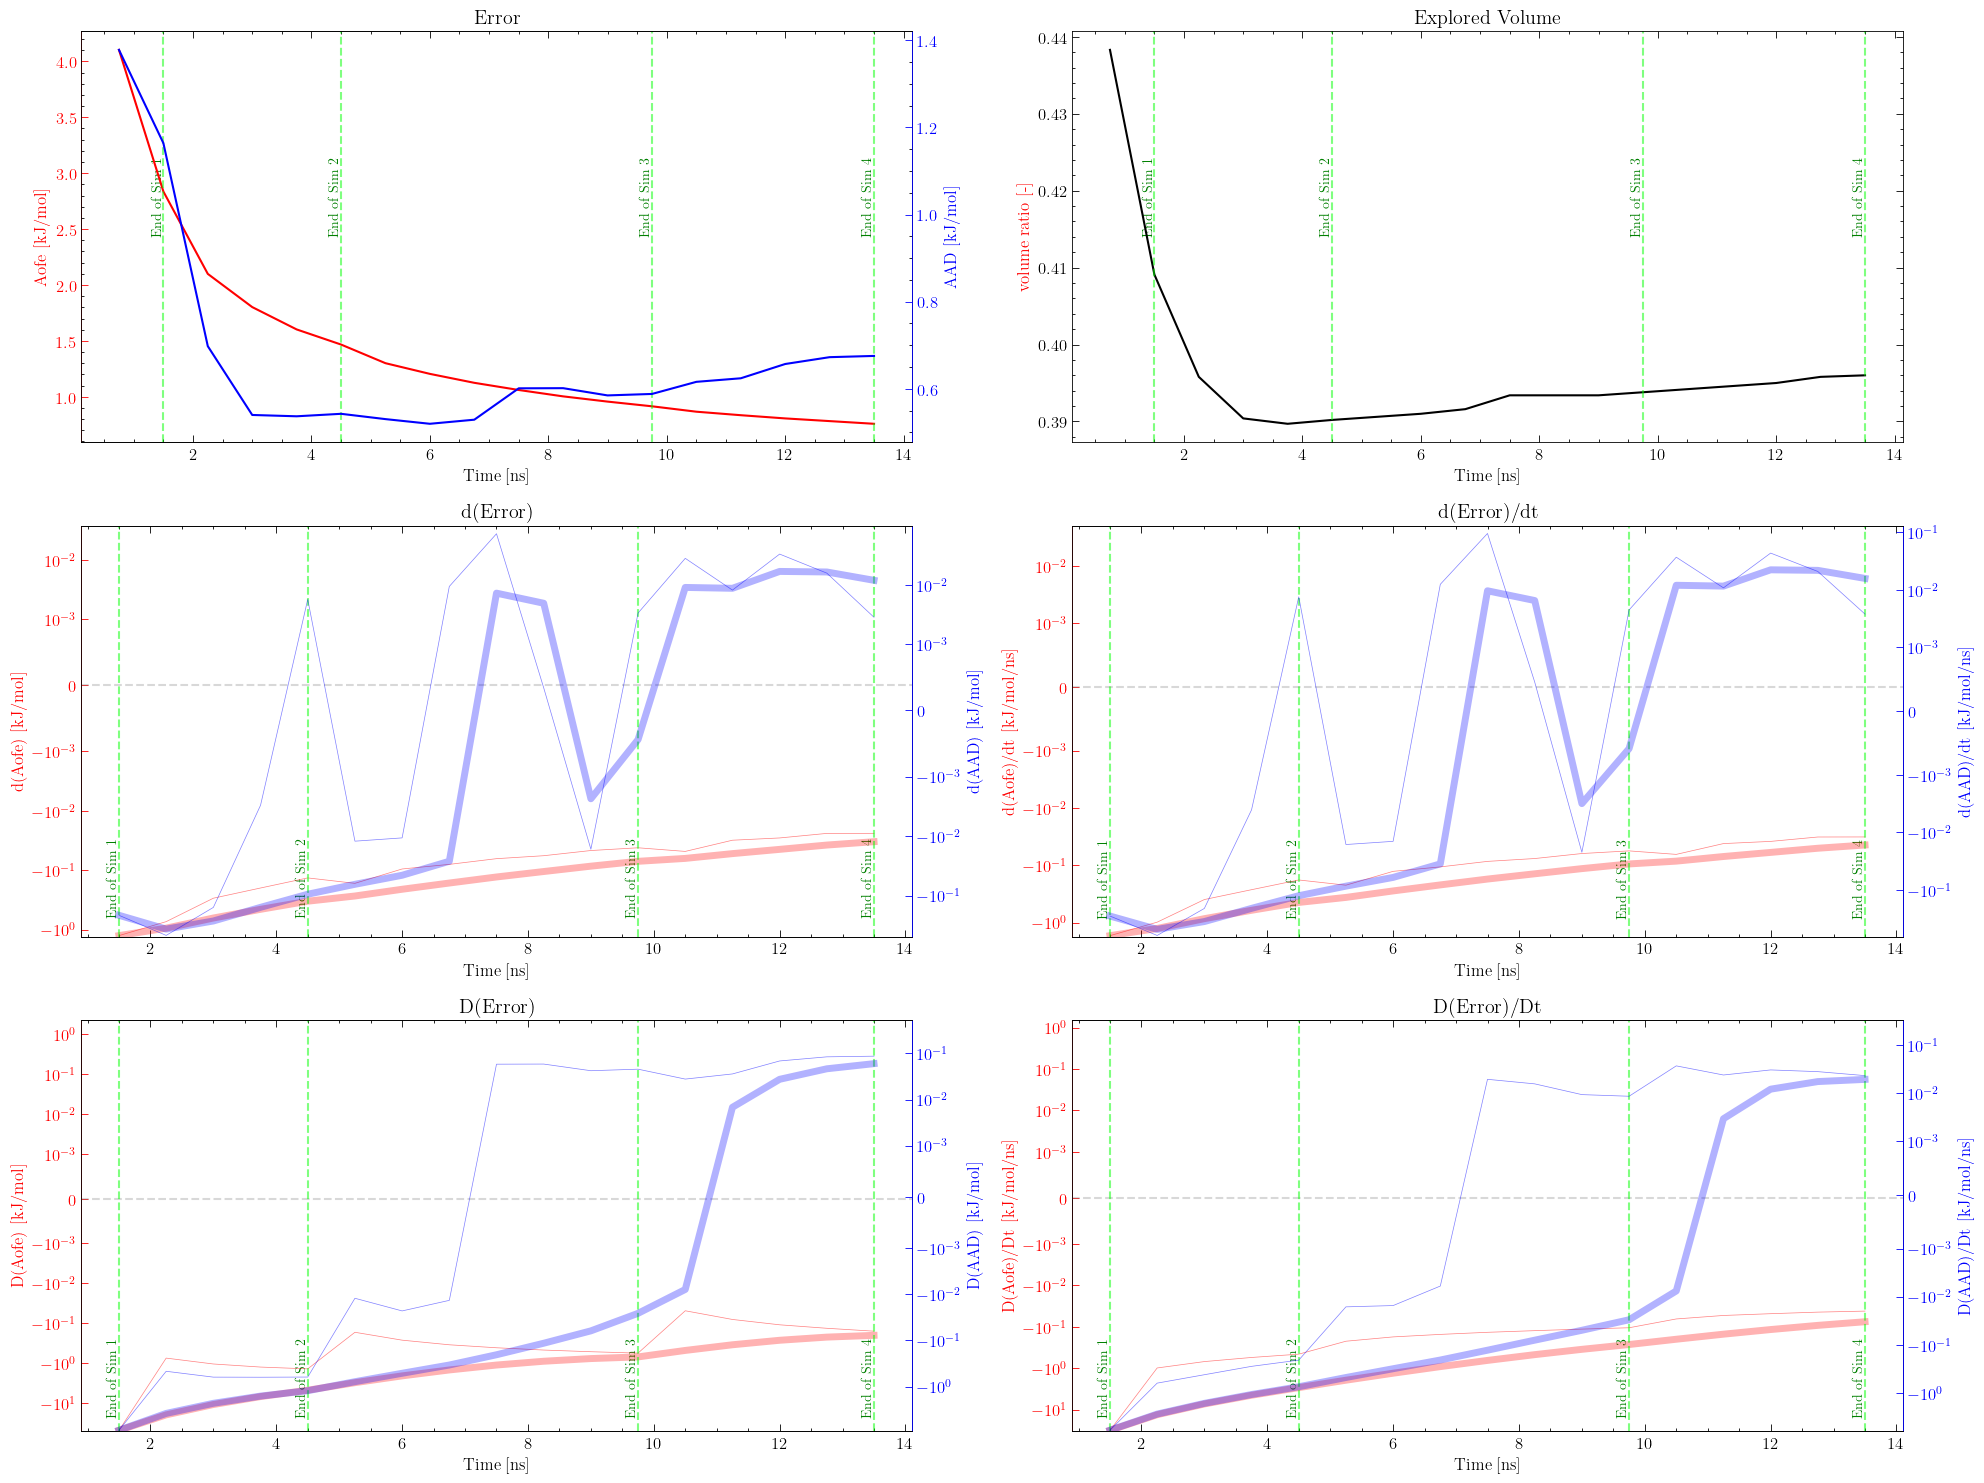

In [8]:
#plot all Error progression    
lib2.plot_all_change_in_error(MFI)

## Alanine Dipeptide

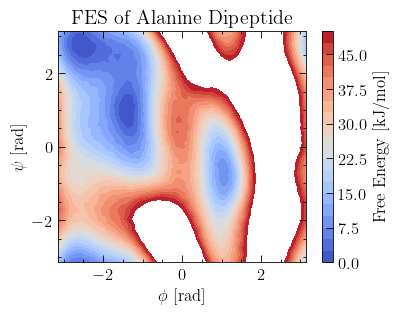

In [16]:
grid = np.linspace(-np.pi, np.pi, 101); 
X, Y = np.meshgrid(grid, grid)
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, periodic=[True, True])

path_AP = path_data + "Alanine_Dipeptide/"
path_input = path_notebook + "/gmx_files/Alanine_Dipeptide/"
plumed_dat_text = f"MOLINFO STRUCTURE={path_input}reference.pdb\nphi: TORSION ATOMS=@phi-2\npsi: TORSION ATOMS=@psi-2\n"

_, _, AP_ref = lib2.load_pkl(path_input + "AP_ref_101x101.pkl")
plt.contourf(X, Y, AP_ref, levels=np.linspace(0, 50, 21), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("$\phi$ [rad]"); plt.ylabel("$\psi$ [rad]"); plt.title("FES of Alanine Dipeptide"); plt.show()

t_compare, v_compare, aofe_compare, aad_compare = lib2.load_pkl(path_input+"AP_10ns_t_v_aofe_aad_prog.pkl")


In [18]:
# default parameters for the MFI class
default_params = {	"X":X, "Y":Y, "Z":AP_ref, "plX":plX, "plY":plY, "periodic":[True, True], "System":"gromacs", "cv_name":["phi","psi"], "plumed_dat_text":plumed_dat_text,
                    "kT":2.49, "time_step":0.001, "simulation_steps":1_000_000, "position_pace":10, "n_pos_per_window":10, 
					"metad_pace":100, "bw":[0.1, 0.1],
         			"len_error_list":50, "FES_cutoff":50.0, # "record_maps":True, "record_forces_e":True, "calculate_FES_st_dev":True, "bootstrap_iter":50,
                    "simulation_folder_path": path_AP, "ID":"",
				  	
                    "find_sim_init_structure":True, "make_tpr_input_file":True, 
					"trajectory_xtc_file_path_list":[path_input+"traj_0.xtc"], "structure_gro_file_path":path_input+"structure.gro", "mdp_file_path":path_input+"gromppvac.mdp", "top_file_path":path_input+"topology.top", "tpr_file_path":path_input+"input.tpr", "pdb_file_path":path_input+"reference.pdb",
           			}


In [8]:
os.chdir(path_notebook); reload(MFI_class2D); reload(lib2); pass

Loading simulation folder: simulation_test2_1
Loading simulation folder: simulation_test2_2
Loading simulation folder: simulation_test2_3
Loading simulation folder: simulation_test2_4
Loading simulation folder: simulation_test2_5
Loading simulation folder: simulation_test2_6
Loading simulation folder: simulation_test2_7
force terms file not found. Calculating force terms with external bias. 
Loading simulation folder: simulation_test2_8
Loading simulation folder: simulation_test2_9
Loading simulation folder: simulation_test2_10
Loading simulation folder: simulation_test2_11
force terms file not found. Calculating force terms with external bias. 
Loading simulation folder: simulation_test2_12

Restarted SRTR campaign with 12 existing simulations and 2.2027 ns existing simulation time.
Aofe = 2.375 | AAD = 2.208 | 
Continuing with phase: metad

~~ S13  START ~~~
~~ S13  PHASE: metad ~~~  | MetaD h= 4.33 , w= [0.1106,0.14707] , bf= 13 | InvF Bias sf= 1, guas sigma = None | 
S13 | t= 0.01n

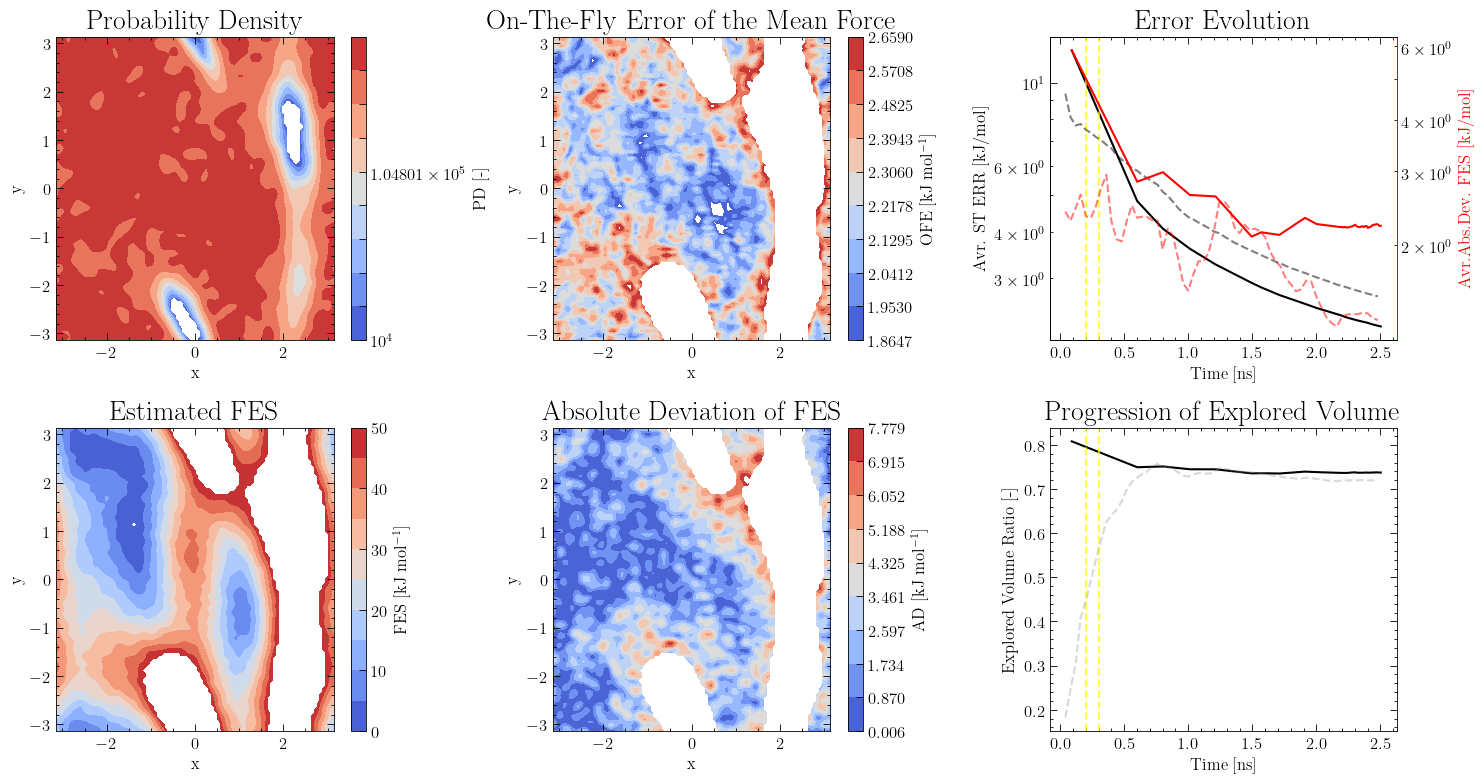


~~~~~~ END ~~~~~~

MFI.Aofe = 2.2255, MFI.AAD = 2.2204


In [22]:
MFI = MFI_class2D.MFI2D(**default_params)

MFI.MFI_real_time_ReInit(ID="_test2", goal=0.1, main_error_type="AAD", n_pos_before_analysis=1000, guaranteed_sim_time=0.2, max_sim_time=0.5,
                        #  time_budget=1)
                         restart_SRTR=True, time_budget=2.5)
                        
MFI.plot_results(t_compare=t_compare, v_compare=v_compare, aofe_compare=aofe_compare, aad_compare=aad_compare)

print(f"\n~~~~~~ END ~~~~~~\n\n{MFI.Aofe = :.4f}, {MFI.AAD = :.4f}")


/home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_SRTR/Alanine_Dipeptide/SRTRcampaign_test2/simulation_test2_13


20080
2008
20080
2008


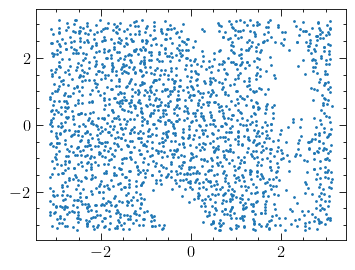

In [30]:
!pwd

os.chdir("/home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_SRTR/Alanine_Dipeptide/SRTRcampaign_test2/simulation_test2_13")

print(len(MFI.position))
print(len(MFI.hills))

MFI.load_data(hills_file="HILLS_test2_13", position_file="position_test2_13", n_pos_analysed=0)

print(len(MFI.position))
print(len(MFI.hills))

plt.scatter(MFI.hills[:,1], MFI.hills[:,2], s=1); plt.show()

## Run over night

In [9]:
os.chdir(path_notebook); reload(MFI_class2D); reload(lib2); pass

In [28]:
# default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":inve_pot, "bw":[0.1, 0.1], "System":"Langevin", "plX":plX, "plY":plY, 
                    "position_pace":50, "n_pos_per_window":10, "metad_pace":500, "Bias_sf":1, "gaus_filter_sigma":1,
                    "FES_cutoff":FES_cutoff, 
                    # "calculate_FES_st_dev":True, "bootstrap_iter":50, 
                    "simulation_folder_path": path_invernizzi}

SRTR_params = { "goal":0.01, "main_error_type":"AAD", "n_pos_before_analysis":1000, "guaranteed_sim_time":5, "max_sim_time":10, "time_budget":30, "ID":""}

In [1]:
# for n_campaign in range(1,15):
    
#     tb = SRTR_params["time_budget"]
#     campaign_id = f"_{n_campaign}_{tb}ns"
#     print(f"\n\n-------- {n_campaign = }, with {campaign_id = }", end=" ")
    
#     if os.path.isfile(path_invernizzi+f"SRTRcampaing{campaign_id}/error_progression{campaign_id}.pkl"): print("Results file exists, skipping campaign"); continue
#     else: print("--------")
    
#     # default_params.update({"simulation_folder_path": path_invernizzi+f"SRTRcampaing{campaign_id}/"})
#     MFI = MFI_class2D.MFI2D(**default_params)
            
#     SRTR_params.update({"ID":campaign_id})
#     MFI.MFI_real_time_ReInit(**SRTR_params)
                    
#     print(f"\n\n~~~~ End of campaign: \n{MFI.Aofe = :.4f}, {MFI.AAD = :.4f}")
        

### Calculate and plot average error progression

In [14]:
path_invernizzi

'/home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_SRTR/Invernizzi_Potential/'

t=[0.25,30.05] | Final avr: AOFE=0.495, AAD=0.583


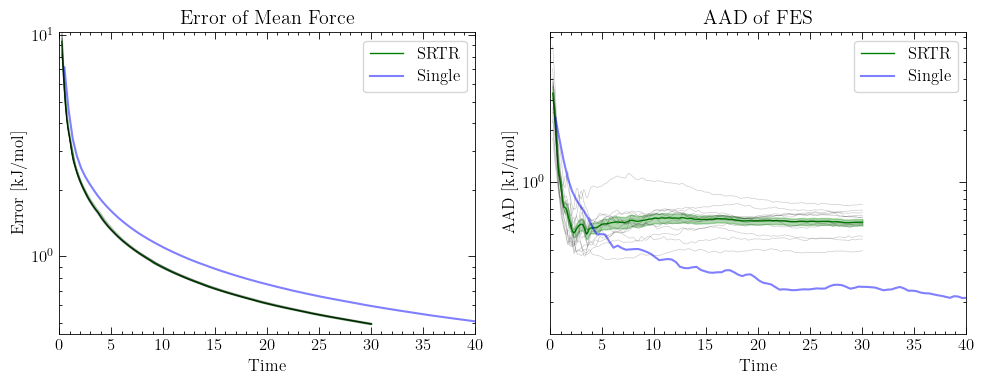

In [19]:
total_campaigns = 13
time_budget = 30

lib2.get_avr_error_prog(path_data=path_invernizzi, total_campaigns=total_campaigns, time_budget=time_budget, include_aad=True, simulation_type="SRTR", show_plot=False, line_label="SRTR")

[time_l, ofe_mean_l, ofe_ste_l, aad_mean_l, aad_ste_l] = lib2.load_pkl(path_notebook + "/error_progressions/error_progression_long_inve.pkl")
plt.subplot(1,2,1); plt.plot(time_l, ofe_mean_l, label="Single", color="blue", alpha=0.5); plt.legend(); plt.xlim(0, 40); 
plt.subplot(1,2,2); plt.plot(time_l, aad_mean_l, label="Single", color="blue", alpha=0.5); plt.legend(); plt.xlim(0, 40); 
plt.tight_layout(); plt.show()